In [1]:
%load_ext autoreload
%autoreload 2

import logging

import matplotlib.pyplot as plt

import defi.tulip.implementation.order as dtuimord
import defi.tulip.implementation.supply_demand as dtimsude
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint

In [2]:
try:
    import pulp
except ImportError:
    !sudo /bin/bash -c "(source /venv/bin/activate; pip install pulp)"
    pass
import defi.tulip.implementation.optimize as dtuimopt

In [3]:
hdbg.init_logger(verbosity=logging.DEBUG)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-6584ff4b-554a-4cfa-81c3-ed1a818d25d6.json'
DEBUG Effective logging level=10
DEBUG Shut up 28 modules: matplotlib.pyplot, matplotlib.ticker, matplotlib.text, matplotlib.category, matplotlib.style, matplotlib.textpath, matplotlib.gridspec, matplotlib.colorbar, matplotlib.axes, matplotlib.artist, matplotlib, matplotlib.axis, matplotlib.style.core, matplotlib.texmanager, matplotlib._layoutgrid, matplotlib._afm, matplotlib.axes._base, matplotlib.image, matplotlib.backend_bases, asyncio, matplotlib.dates, matplotlib.lines, matplotlib.dviread, matplotlib.font_manager, matplotlib._constrained_layout, matplotlib.figure, matplotlib.mathtext, matplotlib.axes._axes
DEBUG > (cd . && cd "$(git rev-parse --show-toplevel)/.." && (git rev-parse --is-inside-work-tree | grep -q true)) 2>&1
DEBUG > (git rev-parse --show-toplevel) 2>&1
-----------------------------------------------------------

# Get aggregated supply / demand

In [4]:
type_ = "supply"
alpha = 2.0
beta = 10.0
n_orders = 10
agg_supply_curve = dtimsude.get_supply_demand_aggregated_curve(
    type_, alpha, beta, n_orders
)
agg_supply_curve

ETH
2.501076      15.002151
2.979722      15.959444
8.693883      27.387767
22.321074     54.642148
27.502932     65.005864
42.192182     94.384364
63.942680    137.885360
67.669949    145.339897
73.647121    157.294243
89.217957    188.435914
Name: BTC.supply, dtype: float64

In [5]:
type_ = "demand"
alpha = -2.0
beta = 210.0
n_orders = 10
agg_demand_curve = dtimsude.get_supply_demand_aggregated_curve(
    type_, alpha, beta, n_orders
)
agg_demand_curve

ETH
2.626129     204.747741
3.128708     203.742584
9.128577     191.742845
23.437128    163.125745
28.878078    152.243843
44.301791    121.396418
67.139814     75.720372
71.053446     67.893108
77.329477     55.341045
93.678855     22.642291
Name: BTC.demand, dtype: float64

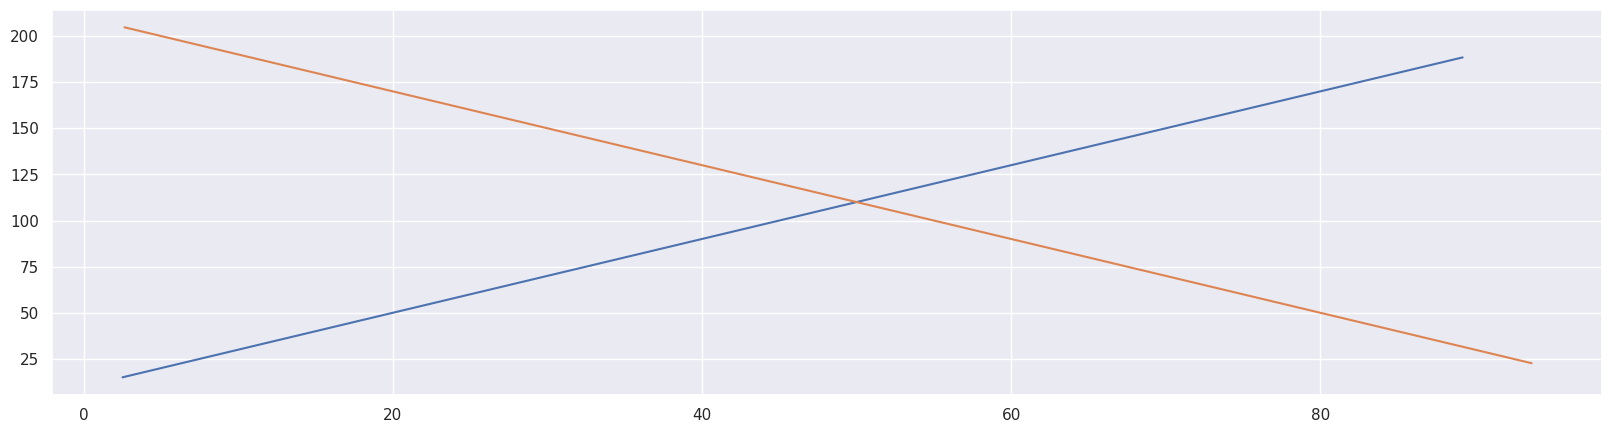

In [6]:
plt.plot(agg_supply_curve)
plt.plot(agg_demand_curve)
plt.show()

In [7]:
agg_supply_orders = dtimsude.convert_aggregated_curve_to_limit_orders(
    agg_supply_curve
)
agg_supply_orders_df = dtuimord.convert_orders_to_dataframe(agg_supply_orders)
agg_supply_orders_df

,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address
0,2023-05-22 12:48:07.307915+00:00,sell,2.501076,BTC,15.002151,ETH,2
1,2023-05-22 12:48:07.308004+00:00,sell,0.478646,BTC,15.959444,ETH,1
2,2023-05-22 12:48:07.308018+00:00,sell,5.714161,BTC,27.387767,ETH,5
3,2023-05-22 12:48:07.308027+00:00,sell,13.627191,BTC,54.642148,ETH,4
4,2023-05-22 12:48:07.308036+00:00,sell,5.181858,BTC,65.005864,ETH,4
5,2023-05-22 12:48:07.308044+00:00,sell,14.68925,BTC,94.384364,ETH,3
6,2023-05-22 12:48:07.308052+00:00,sell,21.750498,BTC,137.88536,ETH,2
7,2023-05-22 12:48:07.308060+00:00,sell,3.727269,BTC,145.339897,ETH,9
8,2023-05-22 12:48:07.308068+00:00,sell,5.977173,BTC,157.294243,ETH,2
9,2023-05-22 12:48:07.308075+00:00,sell,15.570835,BTC,188.435914,ETH,10


In [8]:
agg_demand_orders = dtimsude.convert_aggregated_curve_to_limit_orders(
    agg_demand_curve
)
agg_demand_orders_df = dtuimord.convert_orders_to_dataframe(agg_demand_orders)
agg_demand_orders_df

,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address
0,2023-05-22 12:48:07.352776+00:00,buy,2.626129,BTC,204.747741,ETH,2
1,2023-05-22 12:48:07.352820+00:00,buy,0.502579,BTC,203.742584,ETH,1
2,2023-05-22 12:48:07.352830+00:00,buy,5.999869,BTC,191.742845,ETH,5
3,2023-05-22 12:48:07.352838+00:00,buy,14.30855,BTC,163.125745,ETH,4
4,2023-05-22 12:48:07.352846+00:00,buy,5.440951,BTC,152.243843,ETH,4
5,2023-05-22 12:48:07.352853+00:00,buy,15.423713,BTC,121.396418,ETH,3
6,2023-05-22 12:48:07.352860+00:00,buy,22.838023,BTC,75.720372,ETH,2
7,2023-05-22 12:48:07.352866+00:00,buy,3.913632,BTC,67.893108,ETH,9
8,2023-05-22 12:48:07.352873+00:00,buy,6.276031,BTC,55.341045,ETH,2
9,2023-05-22 12:48:07.352879+00:00,buy,16.349377,BTC,22.642291,ETH,10


# Implement DaoCross and DaoSwap

In [9]:
agg_all_orders = agg_supply_orders + agg_demand_orders
prices = {"BTC": 1, "ETH": 50}

In [10]:
daocross_results = dtuimopt.run_daocross_solver(agg_all_orders, prices)
display(daocross_results)

DEBUG orders=[timestamp=2023-05-22 12:48:07.307915+00:00 action=sell quantity=2.5010755222666936 base_token=BTC limit_price=15.002151044533388 quote_token=ETH deposit_address=2 wallet_address=2, timestamp=2023-05-22 12:48:07.308004+00:00 action=sell quantity=0.47864642154034076 base_token=BTC limit_price=15.959443887614068 quote_token=ETH deposit_address=1 wallet_address=1, timestamp=2023-05-22 12:48:07.308018+00:00 action=sell quantity=5.714161319134581 base_token=BTC limit_price=27.38776652588323 quote_token=ETH deposit_address=5 wallet_address=5, timestamp=2023-05-22 12:48:07.308027+00:00 action=sell quantity=13.62719055194066 base_token=BTC limit_price=54.64214762976455 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-05-22 12:48:07.308036+00:00 action=sell quantity=5.181858022029651 base_token=BTC limit_price=65.00586367382385 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-05-22 12:48:07.308044+00:00 action=sell quantity=14.689250131615118 bas

,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address,q_pi_star,q_tau_star,effective_price
0,2023-05-22 12:48:07.307915+00:00,sell,2.501076,BTC,15.002151,ETH,2,2.501075,125.053780,50.000002
1,2023-05-22 12:48:07.308004+00:00,sell,0.478646,BTC,15.959444,ETH,1,0.478646,23.932321,50.000000
2,2023-05-22 12:48:07.308018+00:00,sell,5.714161,BTC,27.387767,ETH,5,5.714161,285.708070,50.000001
3,2023-05-22 12:48:07.308027+00:00,sell,13.627191,BTC,54.642148,ETH,4,0.000000,0.000000,NaN
4,2023-05-22 12:48:07.308036+00:00,sell,5.181858,BTC,65.005864,ETH,4,0.000000,0.000000,NaN
5,2023-05-22 12:48:07.308044+00:00,sell,14.68925,BTC,94.384364,ETH,3,0.000000,0.000000,NaN
6,2023-05-22 12:48:07.308052+00:00,sell,21.750498,BTC,137.88536,ETH,2,0.000000,0.000000,NaN
7,2023-05-22 12:48:07.308060+00:00,sell,3.727269,BTC,145.339897,ETH,9,0.000000,0.000000,NaN
8,2023-05-22 12:48:07.308068+00:00,sell,5.977173,BTC,157.294243,ETH,2,0.000000,0.000000,NaN
9,2023-05-22 12:48:07.308075+00:00,sell,15.570835,BTC,188.435914,ETH,10,0.000000,0.000000,NaN


In [11]:
daoswap_results = dtuimopt.run_daoswap_solver(agg_all_orders)
display(daoswap_results)

DEBUG orders=[timestamp=2023-05-22 12:48:07.307915+00:00 action=sell quantity=2.5010755222666936 base_token=BTC limit_price=15.002151044533388 quote_token=ETH deposit_address=2 wallet_address=2, timestamp=2023-05-22 12:48:07.308004+00:00 action=sell quantity=0.47864642154034076 base_token=BTC limit_price=15.959443887614068 quote_token=ETH deposit_address=1 wallet_address=1, timestamp=2023-05-22 12:48:07.308018+00:00 action=sell quantity=5.714161319134581 base_token=BTC limit_price=27.38776652588323 quote_token=ETH deposit_address=5 wallet_address=5, timestamp=2023-05-22 12:48:07.308027+00:00 action=sell quantity=13.62719055194066 base_token=BTC limit_price=54.64214762976455 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-05-22 12:48:07.308036+00:00 action=sell quantity=5.181858022029651 base_token=BTC limit_price=65.00586367382385 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-05-22 12:48:07.308044+00:00 action=sell quantity=14.689250131615118 bas

,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address,q_pi_star,q_tau_star,effective_price
0,2023-05-22 12:48:07.307915+00:00,sell,2.501076,BTC,15.002151,ETH,2,2.501075,37.521513,15.002151
1,2023-05-22 12:48:07.308004+00:00,sell,0.478646,BTC,15.959444,ETH,1,0.478646,7.638931,15.959444
2,2023-05-22 12:48:07.308018+00:00,sell,5.714161,BTC,27.387767,ETH,5,5.714161,156.498120,27.387767
3,2023-05-22 12:48:07.308027+00:00,sell,13.627191,BTC,54.642148,ETH,4,13.627191,744.618960,54.642146
4,2023-05-22 12:48:07.308036+00:00,sell,5.181858,BTC,65.005864,ETH,4,5.181858,336.851160,65.005865
5,2023-05-22 12:48:07.308044+00:00,sell,14.68925,BTC,94.384364,ETH,3,14.689250,1386.435500,94.384363
6,2023-05-22 12:48:07.308052+00:00,sell,21.750498,BTC,137.88536,ETH,2,21.750498,2999.075200,137.885358
7,2023-05-22 12:48:07.308060+00:00,sell,3.727269,BTC,145.339897,ETH,9,3.727269,541.720880,145.339898
8,2023-05-22 12:48:07.308068+00:00,sell,5.977173,BTC,157.294243,ETH,2,5.977173,940.174850,157.294242
9,2023-05-22 12:48:07.308075+00:00,sell,15.570835,BTC,188.435914,ETH,10,11.663734,2197.866300,188.435907


# Sanity check with discrete supply / demand

In [12]:
type_ = "supply"
discrete_supply_curve = dtimsude.get_supply_demand_discrete_curve(
    type_, agg_supply_orders_df
)
discrete_supply_curve

ETH
0.000000      15.002151
2.501076      15.002151
2.501076      15.959444
2.979722      15.959444
2.979722      27.387767
8.693883      27.387767
8.693883      54.642148
22.321074     54.642148
22.321074     65.005864
27.502932     65.005864
27.502932     94.384364
42.192182     94.384364
42.192182    137.885360
63.942680    137.885360
63.942680    145.339897
67.669949    145.339897
67.669949    157.294243
73.647121    157.294243
73.647121    188.435914
89.217957    188.435914
89.217957    235.544892
Name: BTC.supply, dtype: float64

In [13]:
type_ = "demand"
discrete_demand_curve = dtimsude.get_supply_demand_discrete_curve(
    type_, agg_demand_orders_df
)
discrete_demand_curve

ETH
0.000000     204.747741
2.626129     204.747741
2.626129     203.742584
3.128708     203.742584
3.128708     191.742845
9.128577     191.742845
9.128577     163.125745
23.437128    163.125745
23.437128    152.243843
28.878078    152.243843
28.878078    121.396418
44.301791    121.396418
44.301791     75.720372
67.139814     75.720372
67.139814     67.893108
71.053446     67.893108
71.053446     55.341045
77.329477     55.341045
77.329477     22.642291
93.678855     22.642291
93.678855      0.000000
Name: BTC.demand, dtype: float64

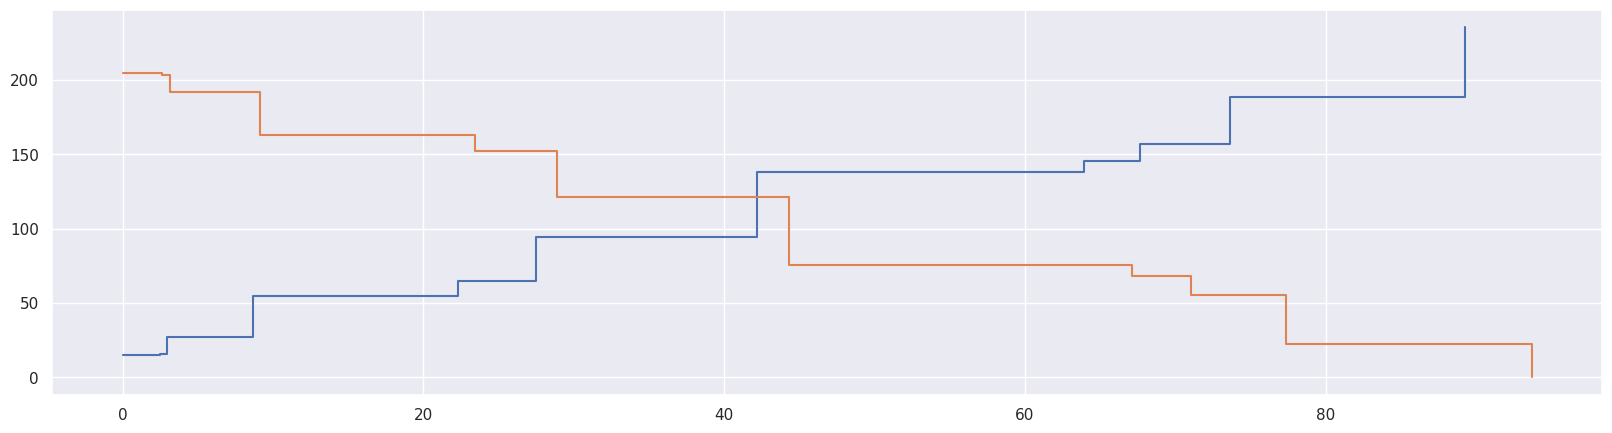

In [14]:
plt.plot(discrete_supply_curve)
plt.plot(discrete_demand_curve)
plt.show()